# Mask R-CNN - Inspect Pothole Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd /content/drive/My\ Drive/Colab\ Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole

/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole


# Training with Custome Dataset:
Train the Model with custom dataset (need to specify the location). Used pre-trained coco weights to save traing time.

In [0]:
!python pothole.py train --dataset="/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset2" --weights=coco

Using TensorFlow backend.
Weights:  coco
Dataset:  /content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset2
Logs:  /content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEAR

# Test the Model Performance 

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.pothole import pothole

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
Pothole_WEIGHTS_PATH = "/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/logs/pothole20191207T2344/mask_rcnn_pothole_0100.h5"  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [0]:
config = pothole.PotholeConfig()
Pothole_DIR = os.path.join("/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole", "dataset4")
# The dataset location needs to be a customized dir

In [7]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [10]:
# Load validation dataset
dataset = pothole.PotholeDataset()
dataset.load_pothole(Pothole_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'pothole']


## Load Model

In [11]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [12]:
# Set path to pothole weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases


# Or, load the last model you trained
weights_path = Pothole_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/logs/pothole20191207T2344/mask_rcnn_pothole_0100.h5






Re-starting from epoch 100


## Run Detection

info: {'id': 'pothole_image5.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset4/val/pothole_image5.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_points_x': [952, 958, 980, 974, 911, 875, 886, 952], 'all_points_y': [863, 858, 828, 775, 789, 841, 882, 863]}, {'name': 'polygon', 'all_points_x': [1256, 1236, 1183, 1178, 1233, 1256], 'all_points_y': [894, 860, 880, 914, 914, 894]}, {'name': 'polygon', 'all_points_x': [1236, 1222, 1170, 1155, 1190, 1256, 1283, 1236], 'all_points_y': [808, 767, 752, 786, 826, 847, 814, 808]}, {'name': 'polygon', 'all_points_x': [694, 640, 692, 728, 720, 694], 'all_points_y': [813, 840, 860, 847, 814, 813]}, {'name': 'polygon', 'all_points_x': [816, 769, 806, 845, 862, 816], 'all_points_y': [701, 677, 655, 677, 684, 701]}]}

info: {'id': 'pothole_image5.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-mast

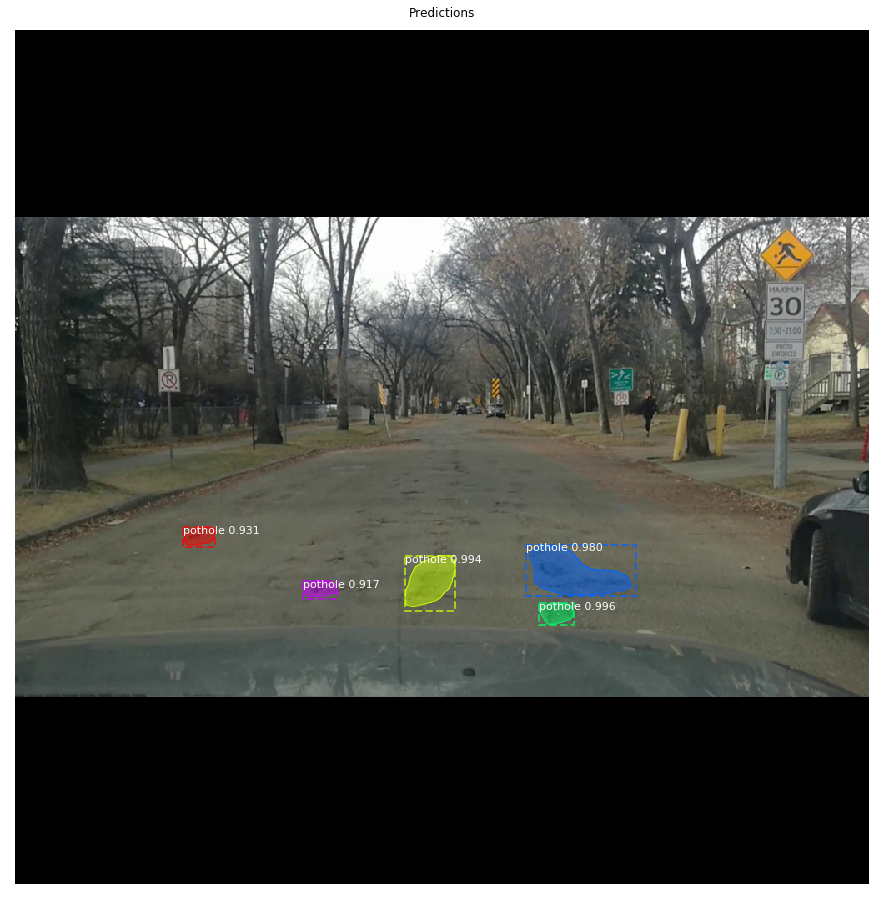

In [0]:
image_id = 4  #random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [0]:
# Compute VOC-style Average Precision
# old weights: the weights without image augmentation

import numpy as np
def compute_batch_ap(image_ids):
    APs = []
    precision = []
    recall = []
    overlap = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
       
        
        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = np.maximum(precisions[i], precisions[i + 1])
        
        APs.append(AP)
        precision.append(precisions)
        recall.append(recalls)
        overlap.append(overlaps)
    return APs, precision, recall, overlap

# Pick a set of random images
image_ids = dataset.image_ids
#image_ids=1
APs, precision, recall, overlap = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))
#print("recall",len(recall))
#print("recall",len(precision[0])) 

info: {'id': 'pothole_image1.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset3/val/pothole_image1.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_points_x': [789, 830, 838, 809, 789, 747, 691, 738, 789], 'all_points_y': [505, 506, 494, 479, 477, 477, 503, 515, 505]}]}

info: {'id': 'pothole_image2.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset3/val/pothole_image2.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_points_x': [1117, 1160, 1168, 1112, 1063, 1117], 'all_points_y': [555, 552, 528, 511, 523, 555]}]}

info: {'id': 'pothole_image3.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset3/val/pothole_image3.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_po

info: {'id': 'pothole_image1.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset4/val/pothole_image1.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_points_x': [789, 830, 838, 809, 789, 747, 691, 738, 789], 'all_points_y': [505, 506, 494, 479, 477, 477, 503, 515, 505]}]}

info: {'id': 'pothole_image2.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset4/val/pothole_image2.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_points_x': [1117, 1160, 1168, 1112, 1063, 1117], 'all_points_y': [555, 552, 528, 511, 523, 555]}]}

info: {'id': 'pothole_image3.jpg', 'source': 'pothole', 'path': '/content/drive/My Drive/Colab Notebooks/Mask-RCNN-series-master/MAsk_RCNN/samples/pothole/dataset4/val/pothole_image3.jpg', 'width': 1920, 'height': 1080, 'polygons': [{'name': 'polygon', 'all_po

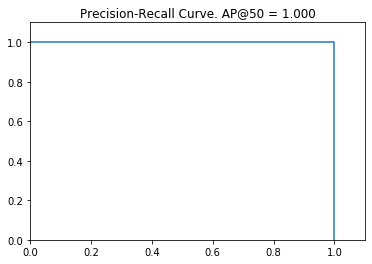

In [0]:
# Compute Average Precision
# new weights
#test precisions and recalls

import numpy as np
def compute_batch_ap(image_ids):
    APs = []
    precision = []
    recall = []
    overlap = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        
        gt_match, pred_match, overlaps = utils.compute_matches(\
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        50)
         # Compute precision and recall at each prediction box step
        #precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
        #recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

        # Pad with start and end values to simplify the math
        #precisions = np.concatenate([[0], precisions, [0]])
        #recalls = np.concatenate([[0], recalls, [1]])
        
        #for i in range(len(precisions) - 2, -1, -1):
            #precisions[i] = np.maximum(precisions[i], precisions[i + 1])
        TP=np.cumsum(pred_match)

      
        APs.append(AP)
        #precision.append(precisions)
        #recall.append(recalls)
        #overlap.append(overlaps)
    return APs, precisions, recalls, overlaps, mAP,TP,AP
def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)
# Pick a set of random images
image_ids = dataset.image_ids
#image_ids=1
APs, precision, recall, overlap, mAP, TP,AP = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))
plot_precision_recall(AP,precision,recall)
#print("recall",recall)
#print("recall",len(precision[0])) 